TODO:

- Loop requests from `ACTIVITY_ID_START` to `END`
- Create an object array to pickle (dunno which properties will become the labels later, or may want to visualize. `pandas` dataframe may be perfect for this...
- Fit into a threadpool impl. to rate-limit requests and be a good citizen
- Save properties of the team (say, light-levels to start) and create a small array with dim `(n_examples, n_features)`
- Save that array. We're now one step closer to world domination!

In [1]:
# How much time would it take to scrape all players?
REQS_PER_SECOND = 25
REQS_PER_DAY = REQS_PER_SECOND * 3600 * 24
n_member_ids = 18000000  # from reddit post

t = n_member_ids / REQS_PER_DAY
f"{t:.2f} days"

'8.33 days'

In [2]:
# How much time would it take to scrape all post-game carnage reports (PGCRs)?
n_pgcrs = 8.4e9  # estimate from one ID I saw on May 7, 2021
t = n_pgcrs / REQS_PER_DAY / 365
f"{t:.2f} years"

'10.65 years'

# Checking dataset structure

In [3]:
# Open pd dataframe here and double check dtypes and multithreaded approach
from os.path import join
import pandas as pd

DATA_COLLECTION_DIR = "/Users/garrick/code/cs229/proj/src/data_collection"
DATA_DIR = "/Users/garrick/code/cs229/proj/src/data"

pass_1_run_1 = "pass_1_run_1.csv"
pass_2_run_1 = "pass_2_run_1.csv"  # with multithreading

# Can parse datetime strings ("period" column)
# Can set the first column as the index
df1 = pd.read_csv(join(DATA_DIR, pass_1_run_1), index_col=0, parse_dates=["period"])
df1

,instance_id,period,director_activity_name,player1_id,player2_id,player3_id,player4_id,player5_id,player6_id,player7_id,player8_id,player9_id,player10_id,player11_id,player12_id,player13_id
0,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,NaN,NaN,NaN,NaN,NaN
1,8400554259,2021-05-07 10:10:04+00:00,The Tangled Shore,2305843009269124957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8400554260,2021-05-07 10:06:08+00:00,Europa,2305843009261667712,2.305843e+18,2.305843e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8400554261,2021-05-07 10:10:14+00:00,K1 Crew Quarters: Legend,2305843009260706831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8400554262,2021-05-07 10:08:26+00:00,H.E.L.M.,2305843009268502892,2.305843e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,8400554354,2021-05-07 10:01:30+00:00,Vanguard Strikes,2305843009394092893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,8400554355,2021-05-07 10:00:47+00:00,Private Match,2305843009265383495,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,2.305843e+18,NaN
98,8400554356,2021-05-07 10:11:42+00:00,The Shattered Throne,2305843009421234603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,8400554357,2021-05-07 10:00:54+00:00,Nightfall: Hero,2305843009278355373,2.305843e+18,2.305843e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df1.dtypes

instance_id                             int64
period                    datetime64[ns, UTC]
director_activity_name                 object
player1_id                              int64
player2_id                            float64
player3_id                            float64
player4_id                            float64
player5_id                            float64
player6_id                            float64
player7_id                            float64
player8_id                            float64
player9_id                            float64
player10_id                           float64
player11_id                           float64
player12_id                           float64
player13_id                           float64
dtype: object

In [5]:
df1["director_activity_name"]  # Reminder: returns a series

0                        Gambit
1             The Tangled Shore
2                        Europa
3      K1 Crew Quarters: Legend
4                      H.E.L.M.
                 ...           
96             Vanguard Strikes
97                Private Match
98         The Shattered Throne
99              Nightfall: Hero
100            Vanguard Strikes
Name: director_activity_name, Length: 101, dtype: object

In [6]:
pass_1_instance_ids = sorted(df1["instance_id"].tolist())
pass_1_instance_ids[:3]

[8400554258, 8400554259, 8400554260]

In [7]:
df2 = pd.read_csv(join(DATA_DIR, pass_2_run_1), index_col=0, parse_dates=["period"])
pass_2_instance_ids = sorted(df2["instance_id"].tolist())
assert pass_2_instance_ids == pass_1_instance_ids

Hooray! Multithreading works!

# Reading Gambit Data

In [19]:
from os.path import join

import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt

DATA_DIR = "/Users/garrick/code/cs229/proj/src/data"
gambit_matches = "gambit.csv"
all_matches = "all.csv"

df = pd.read_csv(join(DATA_DIR, gambit_matches), index_col=0, parse_dates=["period"])
df

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player10_kills,player10_deaths,player10_assists,player10_kdr,player10_kda,player10_efficiency,player10_score,player10_standing,player10_team_score,player10_activity_duration
0,8400554279,2021-05-07 10:05:22+00:00,Gambit,2305843009569834009,23.0,2.0,19.0,11.5,16.25,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,20.0,0.0,10.0,20.0,25.00,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8400554291,2021-05-07 10:05:26+00:00,Gambit,2305843009271267824,16.0,2.0,5.0,8.0,9.25,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8400554313,2021-05-07 10:05:51+00:00,Gambit,2305843009701484298,59.0,1.0,10.0,59.0,64.00,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8400554363,2021-05-07 10:05:41+00:00,Gambit,2305843009570187521,36.0,2.0,9.0,18.0,20.25,22.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,8400564095,2021-05-07 10:12:50+00:00,Gambit,2305843009260445474,26.0,2.0,12.0,13.0,16.00,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,8400564037,2021-05-07 10:12:53+00:00,Gambit,2305843009788775481,25.0,1.0,14.0,25.0,32.00,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,8400564078,2021-05-07 10:13:36+00:00,Gambit,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,8400564223,2021-05-07 10:12:30+00:00,Gambit,2305843009409602637,24.0,2.0,10.0,12.0,14.50,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Other stuff

In [20]:
df_all = pd.read_csv(join(DATA_DIR, all_matches), index_col=0, parse_dates=["period"])
df_all

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player549_kills,player549_deaths,player549_assists,player549_kdr,player549_kda,player549_efficiency,player549_score,player549_standing,player549_team_score,player549_activity_duration
0,8400554275,2021-05-07 09:49:36+00:00,The Dreaming City,2305843009764844975,37.0,6.0,0.0,6.166667,6.166667,6.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8400554270,2021-05-07 09:59:34+00:00,Nightfall: Master,2305843009301445385,42.0,4.0,24.0,10.500000,13.500000,16.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,20.0,0.0,10.0,20.000000,25.000000,30.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8400554260,2021-05-07 10:06:08+00:00,Europa,2305843009261667712,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8400554276,2021-05-07 09:49:30+00:00,Schism,2305843009710054610,32.0,0.0,0.0,32.000000,32.000000,32.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8400564246,2021-05-07 10:17:27+00:00,H.E.L.M.,2305843009278647319,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8785,8400564247,2021-05-07 10:15:28+00:00,H.E.L.M.,2305843009405055417,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8786,8400564141,2021-05-07 10:06:58+00:00,Guardian Games Strikes: Titans,2305843009294749222,56.0,3.0,26.0,18.666667,23.000000,27.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8787,8400564230,2021-05-07 10:05:58+00:00,The Tangled Shore,2305843009608574952,136.0,0.0,0.0,136.000000,136.000000,136.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df[df["director_activity_name"] == "Gambit"] # Example of selecting where =

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player549_kills,player549_deaths,player549_assists,player549_kdr,player549_kda,player549_efficiency,player549_score,player549_standing,player549_team_score,player549_activity_duration
2,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,20.0,0.0,10.0,20.0,25.00,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,8400554279,2021-05-07 10:05:22+00:00,Gambit,2305843009569834009,23.0,2.0,19.0,11.5,16.25,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,8400554313,2021-05-07 10:05:51+00:00,Gambit,2305843009701484298,59.0,1.0,10.0,59.0,64.00,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,8400554363,2021-05-07 10:05:41+00:00,Gambit,2305843009570187521,36.0,2.0,9.0,18.0,20.25,22.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,8400554291,2021-05-07 10:05:26+00:00,Gambit,2305843009271267824,16.0,2.0,5.0,8.0,9.25,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8604,8400564037,2021-05-07 10:12:53+00:00,Gambit,2305843009788775481,25.0,1.0,14.0,25.0,32.00,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8608,8400564049,2021-05-07 10:11:57+00:00,Gambit,2305843009336994851,19.0,2.0,2.0,9.5,10.00,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8631,8400564095,2021-05-07 10:12:50+00:00,Gambit,2305843009260445474,26.0,2.0,12.0,13.0,16.00,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8662,8400564078,2021-05-07 10:13:36+00:00,Gambit,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_all["director_activity_name"].nunique()  # Not sure what count() is for. Non-NaN?

124

In [29]:
df_all["director_activity_name"].count() + 43 # Yes, the above is true

8789

In [69]:
from collections import Counter

activityCounts = Counter()
for aname in df_all["director_activity_name"]:
    activityCounts[aname] += 1

In [71]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
COLORS

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

<BarContainer object of 125 artists>

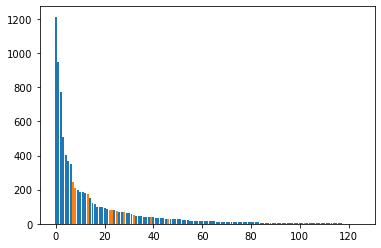

In [72]:
import numpy as np

x, y = zip(*activityCounts.most_common())
pin_activities = ["Nightfall: Master", "Gambit", "Control", "The Shattered Throne", "Prophecy", 'Pit of Heresy: Normal', 'Nightfall: Legend', 'Nightfall: Hero', 'Nightfall: Grandmaster', 'Garden of Salvation', 'Deep Stone Crypt']
bar_colors = [COLORS[0] if a not in pin_activities else COLORS[1] for a in x]
plt.bar(np.arange(len(x)), y, color=bar_colors)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'H.E.L.M.'),
  Text(1, 0, 'Europa'),
  Text(2, 0, 'The Moon'),
  Text(3, 0, 'Cosmodrome'),
  Text(4, 0, 'Vanguard Strikes'),
  Text(5, 0, 'The Tangled Shore'),
  Text(6, 0, 'European Dead Zone'),
  Text(7, 0, 'Nightfall: Hero'),
  Text(8, 0, 'Gambit'),
  Text(9, 0, 'K1 Crew Quarters: Legend')])

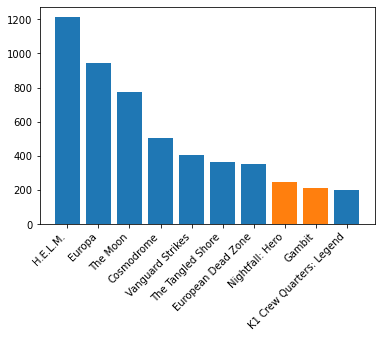

In [79]:
x, y = zip(*activityCounts.most_common(10))
bar_colors = [COLORS[0] if a not in pin_activities else COLORS[1] for a in x]
plt.bar(np.arange(len(x)), y, tick_label=x, color=bar_colors)
plt.xticks(rotation=45, ha="right") # ha - horizontal align

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nightmare Hunt: Insanity: Legend'),
  Text(1, 0, 'Warden of Nothing'),
  Text(2, 0, 'Nightmare Hunt: Fear: Hero'),
  Text(3, 0, '???'),
  Text(4, 0, 'The Hollowed Lair'),
  Text(5, 0, 'The Inverted Spire'),
  Text(6, 0, 'Exodus Crash'),
  Text(7, 0, 'Nightmare Hunt: Despair: Master'),
  Text(8, 0, 'A Hum of Starlight'),
  Text(9, 0, 'Nightmare Hunt: Despair: Hero')])

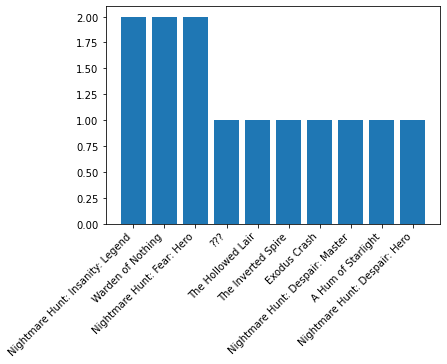

In [80]:
x, y = zip(*activityCounts.most_common()[-10:])
bar_colors = [COLORS[0] if a not in pin_activities else COLORS[1] for a in x]
plt.bar(np.arange(len(x)), y, tick_label=x, color=bar_colors)
plt.xticks(rotation=45, ha="right") # ha - horizontal align

Text(0.5, 1.0, 'Bottom 10 Activities')

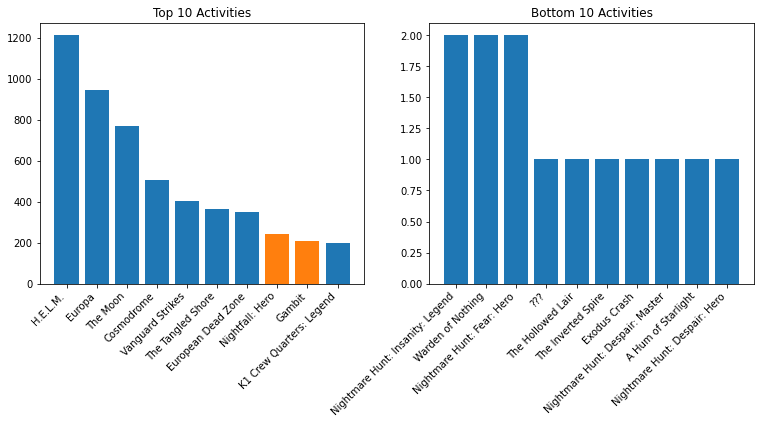

In [83]:
plt.figure(figsize=[6.4 * 2, 4.8])
plt.subplot(1, 2, 1)

x, y = zip(*activityCounts.most_common(10))
bar_colors = [COLORS[0] if a not in pin_activities else COLORS[1] for a in x]
plt.bar(np.arange(len(x)), y, tick_label=x, color=bar_colors)
plt.xticks(rotation=45, ha="right") # ha - horizontal align
plt.title("Top 10 Activities")

plt.subplot(1, 2, 2)

x, y = zip(*activityCounts.most_common()[-10:])
bar_colors = [COLORS[0] if a not in pin_activities else COLORS[1] for a in x]
plt.bar(np.arange(len(x)), y, tick_label=x, color=bar_colors)
plt.xticks(rotation=45, ha="right") # ha - horizontal align
plt.title("Bottom 10 Activities")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Nightfall: Hero'),
  Text(1, 0, 'Gambit'),
  Text(2, 0, 'Control'),
  Text(3, 0, 'Nightfall: Grandmaster'),
  Text(4, 0, 'The Shattered Throne'),
  Text(5, 0, 'Nightfall: Legend'),
  Text(6, 0, 'Prophecy'),
  Text(7, 0, 'Deep Stone Crypt'),
  Text(8, 0, 'Nightfall: Master'),
  Text(9, 0, 'Pit of Heresy: Normal'),
  Text(10, 0, 'Garden of Salvation')])

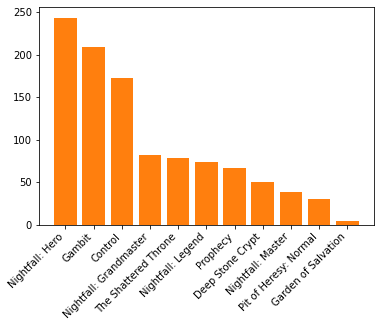

In [74]:
pinned = ["Nightfall: Master", "Gambit", "Control", "The Shattered Throne", "Prophecy", 'Pit of Heresy: Normal', 'Nightfall: Legend', 'Nightfall: Hero', 'Nightfall: Grandmaster', 'Garden of Salvation', 'Deep Stone Crypt']
pins = [(aname, activityCounts[aname]) for aname in pinned]
pins = sorted(pins, key=lambda t: t[1])[::-1] # Sort according to 2nd entry of tuple
x, y = zip(*pins)
plt.bar(np.arange(len(x)), y, tick_label=x, color=COLORS[1])
plt.xticks(rotation=45, ha="right") # ha - horizontal align

In [65]:
keys = [k for k in activityCounts.keys() if type(k) == str]
sorted(keys)

['???',
 'A Cry from Beyond',
 'A Guardian Rises',
 'A Hum of Starlight',
 'A Mysterious Disturbance',
 'Advent',
 'Awakening',
 'Battleground: Behemoth',
 'Battleground: Foothold',
 'Battleground: Hailstone',
 'Battleground: Oracle',
 'Battlegrounds',
 'Beyond',
 'Broken Courier',
 'Choir of the Damned',
 'Cold Boot',
 'Control',
 'Cosmodrome',
 'Coup de Grâce',
 "Darkness's Doorstep",
 'Deep Stone Crypt',
 'Elimination',
 'Empire Hunt: The Dark Priestess: Adept',
 'Empire Hunt: The Dark Priestess: Hero',
 'Empire Hunt: The Dark Priestess: Legend',
 'Empire Hunt: The Dark Priestess: Master',
 'Empire Hunt: The Technocrat',
 'Empire Hunt: The Warrior',
 'Europa',
 'European Dead Zone',
 'Exodus Crash',
 'Exotic Quest: Presage: Master',
 'Exotic Quest: Presage: Normal',
 'Faculties of the Skull',
 'Fallen S.A.B.E.R.',
 'Freelance Glory: Survival',
 'Gambit',
 'Garden of Salvation',
 'Glory: Survival',
 'Guardian Games Strikes: Hunters',
 'Guardian Games Strikes: Titans',
 'Guardian Game

In [84]:
len(keys)

124

# Dataset split and train

In [85]:
df

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player10_kills,player10_deaths,player10_assists,player10_kdr,player10_kda,player10_efficiency,player10_score,player10_standing,player10_team_score,player10_activity_duration
0,8400554279,2021-05-07 10:05:22+00:00,Gambit,2305843009569834009,23.0,2.0,19.0,11.5,16.25,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,20.0,0.0,10.0,20.0,25.00,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8400554291,2021-05-07 10:05:26+00:00,Gambit,2305843009271267824,16.0,2.0,5.0,8.0,9.25,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8400554313,2021-05-07 10:05:51+00:00,Gambit,2305843009701484298,59.0,1.0,10.0,59.0,64.00,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8400554363,2021-05-07 10:05:41+00:00,Gambit,2305843009570187521,36.0,2.0,9.0,18.0,20.25,22.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,8400564095,2021-05-07 10:12:50+00:00,Gambit,2305843009260445474,26.0,2.0,12.0,13.0,16.00,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,8400564037,2021-05-07 10:12:53+00:00,Gambit,2305843009788775481,25.0,1.0,14.0,25.0,32.00,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,8400564078,2021-05-07 10:13:36+00:00,Gambit,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,8400564223,2021-05-07 10:12:30+00:00,Gambit,2305843009409602637,24.0,2.0,10.0,12.0,14.50,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
from sklearn.model_selection import train_test_split

In [89]:

df.columns

Index(['instance_id', 'period', 'director_activity_name', 'player1_char_id',
       'player1_kills', 'player1_deaths', 'player1_assists', 'player1_kdr',
       'player1_kda', 'player1_efficiency',
       ...
       'player10_kills', 'player10_deaths', 'player10_assists', 'player10_kdr',
       'player10_kda', 'player10_efficiency', 'player10_score',
       'player10_standing', 'player10_team_score',
       'player10_activity_duration'],
      dtype='object', length=113)

In [94]:
act_dur_cols = [f"player{idx + 1}_activity_duration" for idx in range(10)]
df[cols]

,player1_activity_duration,player2_activity_duration,player3_activity_duration,player4_activity_duration,player5_activity_duration,player6_activity_duration,player7_activity_duration,player8_activity_duration,player9_activity_duration,player10_activity_duration
0,387.0,387.0,387.0,387.0,387.0,387.0,387.0,387.0,NaN,NaN
1,361.0,361.0,361.0,361.0,361.0,361.0,361.0,361.0,NaN,NaN
2,362.0,362.0,362.0,362.0,362.0,362.0,362.0,362.0,NaN,NaN
3,376.0,376.0,376.0,376.0,376.0,376.0,376.0,376.0,NaN,NaN
4,386.0,386.0,386.0,386.0,386.0,386.0,386.0,386.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
218,351.0,351.0,351.0,351.0,351.0,351.0,351.0,351.0,NaN,NaN
219,354.0,354.0,354.0,354.0,354.0,354.0,354.0,354.0,NaN,NaN
220,325.0,325.0,325.0,325.0,325.0,325.0,325.0,325.0,NaN,NaN
221,394.0,394.0,394.0,394.0,394.0,394.0,394.0,394.0,394.0,NaN


In [95]:
df["activity_duration"] = df["player1_activity_duration"]  # All activity durations are the same

In [124]:
df

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player10_deaths,player10_assists,player10_kdr,player10_kda,player10_efficiency,player10_score,player10_standing,player10_team_score,player10_activity_duration,activity_duration
0,8400554279,2021-05-07 10:05:22+00:00,Gambit,2305843009569834009,23.0,2.0,19.0,11.5,16.25,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.0
1,8400554258,2021-05-07 10:06:12+00:00,Gambit,2305843009764314197,20.0,0.0,10.0,20.0,25.00,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.0
2,8400554291,2021-05-07 10:05:26+00:00,Gambit,2305843009271267824,16.0,2.0,5.0,8.0,9.25,10.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,362.0
3,8400554313,2021-05-07 10:05:51+00:00,Gambit,2305843009701484298,59.0,1.0,10.0,59.0,64.00,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.0
4,8400554363,2021-05-07 10:05:41+00:00,Gambit,2305843009570187521,36.0,2.0,9.0,18.0,20.25,22.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,8400564095,2021-05-07 10:12:50+00:00,Gambit,2305843009260445474,26.0,2.0,12.0,13.0,16.00,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351.0
219,8400564037,2021-05-07 10:12:53+00:00,Gambit,2305843009788775481,25.0,1.0,14.0,25.0,32.00,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0
220,8400564078,2021-05-07 10:13:36+00:00,Gambit,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325.0
221,8400564223,2021-05-07 10:12:30+00:00,Gambit,2305843009409602637,24.0,2.0,10.0,12.0,14.50,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,394.0


In [127]:
# Drop cols fitting regex
df.filter(regex='player9').columns

Index(['player9_char_id', 'player9_kills', 'player9_deaths', 'player9_assists',
       'player9_kdr', 'player9_kda', 'player9_efficiency', 'player9_score',
       'player9_standing', 'player9_team_score', 'player9_activity_duration'],
      dtype='object')

In [131]:
drop_cols = ["period", "director_activity_name", "activity_duration"]
X = df.drop(act_dur_cols, axis=1)
X = X.drop(drop_cols, axis=1)
X = X.drop(X.filter(regex='player9').columns, axis=1)
X = X.drop(X.filter(regex='player10').columns, axis=1)
X

,instance_id,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,player1_score,player1_standing,...,player8_char_id,player8_kills,player8_deaths,player8_assists,player8_kdr,player8_kda,player8_efficiency,player8_score,player8_standing,player8_team_score
0,8400554279,2305843009569834009,23.0,2.0,19.0,11.5,16.25,21.0,40.0,0.0,...,2305843009625815306,21.0,6.0,4.0,3.500000,3.833333,4.166667,5.0,0.0,0.0
1,8400554258,2305843009764314197,20.0,0.0,10.0,20.0,25.00,30.0,36.0,1.0,...,2305843009300169870,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0
2,8400554291,2305843009271267824,16.0,2.0,5.0,8.0,9.25,10.5,39.0,0.0,...,2305843009508085659,11.0,3.0,9.0,3.666667,5.166667,6.666667,7.0,0.0,0.0
3,8400554313,2305843009701484298,59.0,1.0,10.0,59.0,64.00,69.0,60.0,1.0,...,2305843009508024021,16.0,2.0,14.0,8.000000,11.500000,15.000000,5.0,1.0,1.0
4,8400554363,2305843009570187521,36.0,2.0,9.0,18.0,20.25,22.5,55.0,1.0,...,2305843009511975145,19.0,1.0,19.0,19.000000,28.500000,38.000000,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,8400564095,2305843009260445474,26.0,2.0,12.0,13.0,16.00,19.0,34.0,1.0,...,2305843009269373683,18.0,4.0,8.0,4.500000,5.500000,6.500000,0.0,0.0,0.0
219,8400564037,2305843009788775481,25.0,1.0,14.0,25.0,32.00,39.0,30.0,1.0,...,2305843009688474571,8.0,1.0,7.0,8.000000,11.500000,15.000000,0.0,0.0,0.0
220,8400564078,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,32.0,0.0,...,2305843009728724748,7.0,3.0,3.0,2.333333,2.833333,3.333333,8.0,1.0,1.0
221,8400564223,2305843009409602637,24.0,2.0,10.0,12.0,14.50,17.0,44.0,1.0,...,2305843009388796548,23.0,2.0,9.0,11.500000,13.750000,16.000000,7.0,1.0,1.0


In [132]:
y = df["activity_duration"]
y

0      387.0
1      361.0
2      362.0
3      376.0
4      386.0
       ...  
218    351.0
219    354.0
220    325.0
221    394.0
222    378.0
Name: activity_duration, Length: 223, dtype: float64

In [133]:
train_X, valtest_X, train_y, valtest_y = train_test_split(X, y, test_size=0.2, random_state=229)
val_X, test_X, val_y, test_y = train_test_split(valtest_X, valtest_y, test_size=0.5, random_state=229)
train_X

,instance_id,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,player1_score,player1_standing,...,player8_char_id,player8_kills,player8_deaths,player8_assists,player8_kdr,player8_kda,player8_efficiency,player8_score,player8_standing,player8_team_score
136,8400560894,2305843009587344137,33.0,3.0,9.0,11.0,12.50,14.0,46.0,0.0,...,2305843009350014028,35.0,3.0,15.0,11.666667,14.166667,16.666667,15.0,1.0,1.0
111,8400559306,2305843009359006294,44.0,2.0,13.0,22.0,25.25,28.5,42.0,0.0,...,2305843009758104182,10.0,2.0,18.0,5.000000,9.500000,14.000000,13.0,0.0,0.0
32,8400555584,2305843009261821118,25.0,1.0,8.0,25.0,29.00,33.0,47.0,1.0,...,2305843009621595558,18.0,2.0,11.0,9.000000,11.750000,14.500000,6.0,1.0,1.0
59,8400556719,2305843009319394098,21.0,2.0,25.0,10.5,16.75,23.0,41.0,0.0,...,2305843009750274138,26.0,5.0,18.0,5.200000,7.000000,8.800000,6.0,0.0,0.0
109,8400559072,2305843009394870276,31.0,2.0,9.0,15.5,17.75,20.0,41.0,0.0,...,2305843009266018257,16.0,4.0,8.0,4.000000,5.000000,6.000000,12.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,8400562172,2305843009603244191,38.0,0.0,12.0,38.0,44.00,50.0,36.0,1.0,...,2305843009573894263,2.0,1.0,3.0,2.000000,3.500000,5.000000,0.0,0.0,0.0
99,8400558818,2305843009260683247,18.0,0.0,9.0,18.0,22.50,27.0,34.0,0.0,...,2305843009472384298,24.0,1.0,11.0,24.000000,29.500000,35.000000,14.0,1.0,1.0
220,8400564078,2305843009502444525,16.0,1.0,3.0,16.0,17.50,19.0,32.0,0.0,...,2305843009728724748,7.0,3.0,3.0,2.333333,2.833333,3.333333,8.0,1.0,1.0
45,8400556149,2305843009260886165,27.0,2.0,12.0,13.5,16.50,19.5,45.0,0.0,...,2305843009409723631,12.0,1.0,11.0,12.000000,17.500000,23.000000,10.0,1.0,1.0


In [161]:
model = LinearRegression().fit(train_X, train_y)
train_score = model.score(train_X, train_y)
val_score = model.score(val_X, val_y)
print(f"train: {train_score}")
print(f"val: {val_score}")

train: 0.8298650220838719
val: 0.6943872096383797


In [162]:
model = LinearRegression(normalize=True).fit(train_X, train_y)
train_score = model.score(train_X, train_y)
val_score = model.score(val_X, val_y)
print(f"train: {train_score}")
print(f"val: {val_score}")

train: 0.8267999022770446
val: 0.6803182983325679


In [173]:
reg_strengths = [0.03, 0.1, 0.3, 1, 3, 10]

for reg_strength in reg_strengths:
    model = Ridge(normalize=True, alpha=reg_strength).fit(train_X, train_y)
    train_score = model.score(train_X, train_y)
    val_score = model.score(val_X, val_y)
#     print(f"reg str: {reg_strength}")
#     print(f"train: {train_score}")
#     print(f"val: {val_score}")
#     print()
    print(f"{reg_strength} & {train_score:.4f} & {val_score:.4f}")

0.03 & 0.8252 & 0.6959
0.1 & 0.8208 & 0.7115
0.3 & 0.8091 & 0.7265
1 & 0.7749 & 0.7371
3 & 0.6984 & 0.7136
10 & 0.5081 & 0.5568


In [174]:
reg_strengths = [0.03, 0.1, 0.3, 1, 3, 10]

print("reg str & train r2 & val r2")
for reg_strength in reg_strengths:
    model = Lasso(normalize=True, max_iter=3000, alpha=reg_strength).fit(train_X, train_y)
    train_score = model.score(train_X, train_y)
    val_score = model.score(val_X, val_y)
    print(f"{reg_strength} & {train_score:.4f} & {val_score:.4f}")

reg str & train r2 & val r2
0.03 & 0.8224 & 0.6817
0.1 & 0.8153 & 0.6745
0.3 & 0.7959 & 0.7135
1 & 0.7253 & 0.7667
3 & 0.4121 & 0.4442
10 & 0.0000 & -0.0348


In [178]:
# My best model
model = Lasso(normalize=True, max_iter=3000, alpha=1.0).fit(train_X, train_y)
test_score = model.score(test_X, test_y)
test_score

0.6463089694612295

In [188]:
mask = model.sparse_coef_.toarray().flatten() > 0

In [194]:
labels = test_X.columns[mask].tolist()

In [195]:
weights = model.sparse_coef_.toarray().flatten()[mask]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'player4_deaths'),
  Text(1, 0, 'player1_deaths'),
  Text(2, 0, 'player7_deaths'),
  Text(3, 0, 'player2_deaths'),
  Text(4, 0, 'player3_deaths'),
  Text(5, 0, 'player8_deaths'),
  Text(6, 0, 'player5_deaths'),
  Text(7, 0, 'player6_deaths'),
  Text(8, 0, 'player4_assists'),
  Text(9, 0, 'player4_kills'),
  Text(10, 0, 'player4_score'),
  Text(11, 0, 'player3_score'),
  Text(12, 0, 'player2_assists')])

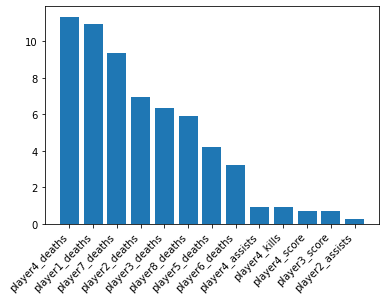

In [196]:
col_weights = [(l, w) for l, w in zip(labels, weights)]
col_weights = sorted(col_weights, key=lambda t: t[1])[::-1] # Sort according to 2nd entry of tuple
x, y = zip(*col_weights)
plt.bar(np.arange(len(x)), y, tick_label=x, color=COLORS[0])
plt.xticks(rotation=45, ha="right") # ha - horizontal align

# Look at all 100k dataset

In [198]:
all_matches_100k = "all_100k.csv"

df_all100k = pd.read_csv(join(DATA_DIR, all_matches_100k), index_col=0, parse_dates=["period"])
df_all100k

,instance_id,period,director_activity_name,player1_char_id,player1_kills,player1_deaths,player1_assists,player1_kdr,player1_kda,player1_efficiency,...,player1045_kills,player1045_deaths,player1045_assists,player1045_kdr,player1045_kda,player1045_efficiency,player1045_score,player1045_standing,player1045_team_score,player1045_activity_duration
0,8400554263,2021-05-07 09:56:24+00:00,Europa,2305843009673234407,105.0,0.0,0.0,105.000000,105.000000,105.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8400554264,2021-05-07 10:09:59+00:00,H.E.L.M.,2305843009261481875,0.0,0.0,0.0,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8400554268,2021-05-07 09:42:43+00:00,Nightfall: Master,2305843009395423064,149.0,1.0,0.0,149.000000,149.000000,149.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8400554261,2021-05-07 10:10:14+00:00,K1 Crew Quarters: Legend,2305843009260706831,10.0,2.0,0.0,5.000000,5.000000,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8400554280,2021-05-07 09:59:02+00:00,Schism,2305843009796844626,55.0,0.0,0.0,55.000000,55.000000,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80021,8400654254,2021-05-07 11:16:42+00:00,Europa,2305843009577454319,36.0,0.0,0.0,36.000000,36.000000,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80022,8400654225,2021-05-07 11:09:54+00:00,Vanguard Strikes,2305843009639155164,0.0,0.0,0.0,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80023,8400654238,2021-05-07 10:28:19+00:00,Europa,2305843009264081861,72.0,0.0,7.0,72.000000,75.500000,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80024,8400654248,2021-05-07 11:19:47+00:00,The Moon,2305843009602874151,0.0,0.0,0.0,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
